In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/rtandon32/ebm/pySuStaIn/sim/')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cbook as cbook

import os

import pandas as pd

from simfuncs import *

from functools import partial, partialmethod
from kde_ebm.mixture_model import fit_all_gmm_models, fit_all_kde_models
from kde_ebm import plotting

import warnings
#warnings.filterwarnings("ignore",category=cbook.mplDeprecation)

from pySuStaIn.sEBMSustain import sEBMSustainData
from pySuStaIn.sEBMSustain import sEBMSustain
from pySuStaIn.ZscoreSustain  import ZscoreSustain
from pySuStaIn.MixtureSustain import MixtureSustain

import sklearn.model_selection

import pylab

In [6]:
N                       = 10         # number of biomarkers
M                       = 800       # number of observations ( e.g. subjects )
N_S_ground_truth        = 3         # number of ground truth subtypes
stage_sizes = [2,3,3,2]
# the fractions of the total number of subjects (M) belonging to each subtype
ground_truth_fractions = np.array([0.5, 0.30, 0.20])

#create some generic biomarker names
BiomarkerNames           = ['Biomarker ' + str(i) for i in range(N)]

#***************** parameters for SuStaIn-based inference of subtypes
use_parallel_startpoints = True

# number of starting points
N_startpoints           = 25
# maximum number of inferred subtypes - note that this could differ from N_S_ground_truth
N_S_max                 = 2
N_iterations_MCMC       = int(1e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice

#labels for plotting are biomarker names
SuStaInLabels           = BiomarkerNames

# cross-validation
validate                = True
N_folds                 = 3         #Set low to speed things up here, but generally recommend 10 in practice

#either 'mixture_GMM' or 'mixture_KDE' or 'zscore'
sustainType             = 'mixture_GMM'

In [7]:
dataset_name            = 'simx2'
output_folder           = os.path.join(os.getcwd(), dataset_name + '_' + sustainType)
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [9]:
ground_truth_subj_ids   = list(np.arange(1, M+1).astype('str'))
ground_truth_sequences  = generate_random_mixture_sustain_model(N, N_S_ground_truth)

ground_truth_subtypes   = np.random.choice(range(N_S_ground_truth), M, replace=True, p=ground_truth_fractions).astype(int)

N_stages                = N

ground_truth_stages_control = np.zeros((int(np.round(M * 0.25)), 1))
ground_truth_stages_other   = np.random.randint(1, N_stages+1, (int(np.round(M * 0.75)), 1))
ground_truth_stages         = np.vstack((ground_truth_stages_control, ground_truth_stages_other)).astype(int)

data, data_denoised     = generate_data_mixture_sustain(ground_truth_subtypes, ground_truth_stages, ground_truth_sequences, sustainType)

/home/rtandon32/.conda/envs/sustain/lib/python3.9/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


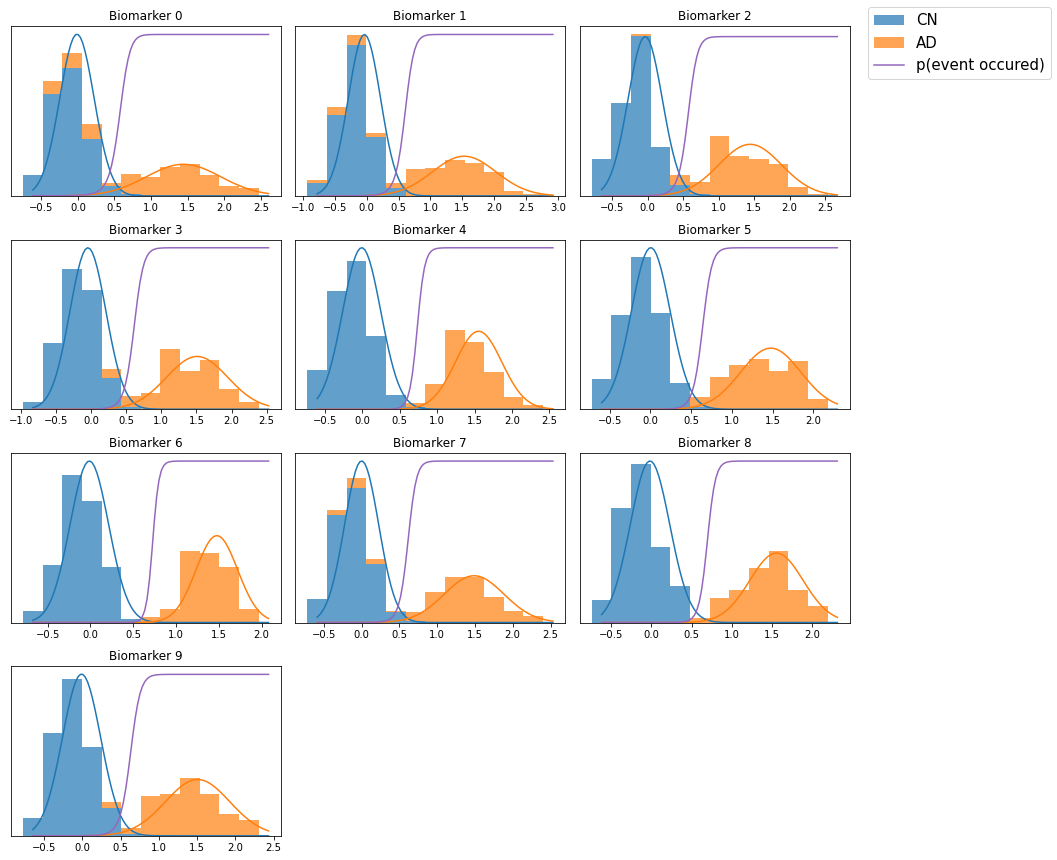

In [10]:
# choose which subjects will be cases and which will be controls
MIN_CASE_STAGE          = np.round((N + 1) * 0.8)
index_case              = np.where(ground_truth_stages >=  MIN_CASE_STAGE)[0]
index_control           = np.where(ground_truth_stages ==  0)[0]

labels                  = 2 * np.ones(data.shape[0], dtype=int)     # 2 - intermediate value, not used in mixture model fitting
labels[index_case]      = 1                                         # 1 - cases
labels[index_control]   = 0                                         # 0 - controls

data_case_control       = data[labels != 2, :]
labels_case_control     = labels[labels != 2]

if sustainType == "mixture_GMM":
    mixtures            = fit_all_gmm_models(data, labels)
elif sustainType == "mixture_KDE":
    mixtures            = fit_all_kde_models(data, labels)

fig, ax                 = plotting.mixture_model_grid(data_case_control, labels_case_control, mixtures, SuStaInLabels)#, plotting_font_size=20)
fig.show()
fig.savefig(os.path.join(output_folder, 'kde_fits.png'))

L_yes                   = np.zeros(data.shape)
L_no                    = np.zeros(data.shape)
for i in range(N):
    if sustainType == "mixture_GMM":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(None, data[:, i])
    elif sustainType   == "mixture_KDE":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(data[:, i].reshape(-1, 1))

In [11]:
sustain = sEBMSustain(L_yes, L_no, stage_sizes, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC, output_folder, dataset_name, use_parallel_startpoints)

In [12]:
rng = np.random.default_rng(0)
seq_init = sustain._initialise_sequence(sustain._sEBMSustain__sustainData, rng)
flattened = sustain._flatten_S_dict(seq_init[0])
flattened

array([4, 6, 2, 7, 3, 5, 9, 0, 8, 1])

In [13]:
seq_init

[{0: array([4, 6]),
  1: array([2, 7, 3]),
  2: array([5, 9, 0]),
  3: array([8, 1])}]

In [14]:
seq_init

[{0: array([4, 6]),
  1: array([2, 7, 3]),
  2: array([5, 9, 0]),
  3: array([8, 1])}]

In [15]:
sustain._dictionarize_sequence(flattened)

{0: array([4, 6]), 1: array([2, 7, 3]), 2: array([5, 9, 0]), 3: array([8, 1])}

In [16]:
a, b, c, _, _, _ = sustain._perform_em(sustain._sEBMSustain__sustainData, [seq_gt1, seq_gt2], [0.2,0.8], rng)

NameError: name 'seq_gt1' is not defined

In [ ]:
a, b, c, d, e, f = sustain._estimate_ml_sustain_model_nplus1_clusters(sustain._sEBMSustain__sustainData, [seq_gt1, seq_gt2], [0.6,0.4])

In [ ]:
a

In [ ]:
# a1, _, _, _, _, _ = sustain._find_ml(sustain._sEBMSustain__sustainData)

In [ ]:
1+1

In [ ]:
seed_seq = np.random.SeedSequence(sustain.global_rng.integers(1e10))

In [ ]:
a, b, c = sustain._find_ml_split_iteration(sustain._sEBMSustain__sustainData, seed_seq)

In [ ]:
a

In [ ]:
a,b,c,_,_,_  = sustain._find_ml_mixture_iteration(sustain._sEBMSustain__sustainData, a, [0.5,0.5], seed_seq)

In [ ]:
x = np.random.randn(5,3)
x[:,1][:,0]

In [ ]:
sustain._find_ml_mixture_iteration(sustain._sEBMSustain__sustainData, a, b, seed_seq)

In [ ]:
sustain._optimise_parameters(sustain._sEBMSustain__sustainData, seq_init, [1], rng)

In [ ]:
sustain._calculate_likelihood(sustain._sEBMSustain__sustainData, [seq_gt1, seq_gt2], [0.6,0.4])
# np.log(sustain._calculate_likelihood(sustain._sEBMSustain__sustainData, [seq_gt1, seq_gt2], [0.6,0.4]).sum(axis=1)).sum()

In [ ]:
ground_truth_sequences

In [ ]:
seq_gt1 = {0: np.array([1,4]), 1: np.array([5,7,2]), 2: np.array([9,0,8]), 3: np.array([6,3])}
seq_gt2 = {0: np.array([7,9]), 1: np.array([5,6,1]), 2: np.array([4,0,3]), 3: np.array([2,8])}

In [ ]:
ground_truth_sequences , ground_truth_fractions

In [ ]:
x = np.ones((4,1))
x

In [ ]:
np.argmax(x)

In [ ]:
seq_init

In [ ]:
sustain._calculate_likelihood_stage(sustain._sEBMSustain__sustainData, seq_init[0])

In [ ]:
#****** plot the ground truth sequences
ground_truth_sequences              = np.expand_dims(ground_truth_sequences, axis=2)
ground_truth_fractions_actual, _    = np.histogram(ground_truth_subtypes, bins=np.arange(N_S_ground_truth + 1) - 0.5)
ground_truth_fractions_actual       = ground_truth_fractions_actual/len(ground_truth_subtypes)
ground_truth_fractions_actual       = np.expand_dims(ground_truth_fractions_actual, axis=1)
ground_truth_nsamples               = np.inf

In [ ]:
#ordering of positional variance diagrams (PVDs)
plot_subtype_order      = np.arange(N_S_ground_truth)
#ordering of biomarkers in each PVD
plot_biomarker_order    = ground_truth_sequences[plot_subtype_order[0], :].astype(int).ravel()
#plot PVDs given subtype and biomarker ordering
figs, ax                 = sustain._plot_sustain_model(ground_truth_sequences, ground_truth_fractions_actual, ground_truth_nsamples, \
                                                      subtype_order=plot_subtype_order, biomarker_order=plot_biomarker_order, title_font_size=12)
figs[0].suptitle('Ground truth sequences')
figs[0].savefig(os.path.join(output_folder, 'PVD_true.png'))
figs[0].show()

In [ ]:
# print block
# sustain._initialise_sequence(sustain._sEBMSustain__sustainData)
rng = np.random.default_rng()
rng.permutation(6).reshape(1, 6)

Failed to find pickle file: /home2/rtandon32/ebm/pySuStaIn/notebooks/simx2_mixture_GMM/pickle_files/simx2_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -18026.75004007675


AttributeError: 'list' object has no attribute 'shape'

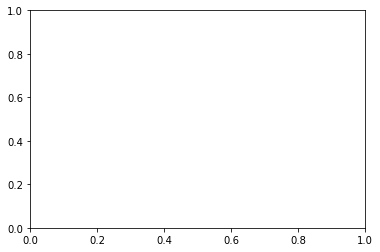

In [17]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage      = sustain.run_sustain_algorithm(plot=True)

In [ ]:
sdata = sEBMSustainData(L_yes, L_no, stage_sizes)

In [ ]:
partial_iter = partial(sustain._find_ml_iteration, sdata)
seed_sequences = np.random.SeedSequence(np.random.default_rng(10).integers(1e10))

In [ ]:
partial_iter(seed_sequences.spawn(1)[0])

In [ ]:
#save the most likely subtype, the associated subtype probability,
# the most likely stage and the associated stage probability for each subject
df                      = pd.DataFrame()
df['subj_id']           = ground_truth_subj_ids
df['ml_subtype']        = ml_subtype
df['prob_ml_subtype']   = prob_ml_subtype
df['ml_stage']          = ml_stage
df['prob_ml_stage']     = prob_ml_stage
df.to_csv(os.path.join(output_folder, 'Subject_subtype_stage_estimates.csv'), index=False)

FONT_SIZE               = 15

#plot the inferred subtypes as histograms binned by true subtype
plt.style.use('seaborn-deep')
bins                    = np.arange(0, N_S_ground_truth+1)
X_hist                  = list()
labels_hist             = list()
for i in range(N_S_max):
    X_hist.append(ml_subtype[ground_truth_subtypes==i].ravel())
    labels_hist.append('Subtype ' + str(i+1))
fig, ax = plt.subplots()
ax.hist(X_hist, bins, label=labels_hist)
ax.set_xticks(np.arange(0, N_S_ground_truth)+0.5)
ax.set_xticklabels(np.arange(1, N_S_ground_truth+1))
ax.set_xlabel('Estimated subtype', fontsize=FONT_SIZE)
ax.set_title('')
ax.legend(loc='upper right', fontsize=FONT_SIZE)
fig.savefig(os.path.join(output_folder, 'Subtype_estimate_histograms.png'))
fig.show()

In [ ]:
#plot the inferred stages as boxplots binned by true stage
df_boxplot                  = pd.DataFrame()
df_boxplot['subtypes_true'] = ground_truth_subtypes
df_boxplot['subtypes_est']  = ml_subtype
df_boxplot['stages_true']   = ground_truth_stages
df_boxplot['stages_est']    = ml_stage
fig, ax = plt.subplots()
df_boxplot.boxplot(column='stages_est', by='stages_true', grid=False, fontsize=FONT_SIZE, ax=ax)
ax.set_xlabel('True stages',       fontsize=FONT_SIZE)
ax.set_ylabel('Estimated stages',  fontsize=FONT_SIZE)
ax.set_title('')
fig.savefig(os.path.join(output_folder, 'Stage_estimate_boxplots.png'))
fig.show()

In [ ]:
a = np.random.randn(3,5)

In [ ]:
np.unravel_index(np.argmax(a, axis=None), a.shape)

In [ ]:
np.hstack([[])

In [33]:
def _dictionarize_sequence(S, stage_size):
    # S is array
    stages_cumsum = np.cumsum(stage_size)
    S_dict = {}

    for _ in range(len(stage_size)-1,0,-1):
        # if _ == 0:
        #     idx = (0, stages_cumsum[_])
        # else:
        idx = (stages_cumsum[_-1], stages_cumsum[_])
        stage = S[idx[0]: idx[1]]
        S_dict[_] = stage
    S_dict[0] = S[0:idx[0]]
    S_dict_ = {i:S_dict[i] for i in range(len(stage_size))}
    return S_dict_

In [34]:
stage_size = [3,4,4,3]
S = rng.permutation(sum(stage_size))
_dictionarize_sequence(S, stage_size)


{0: array([9, 5, 7]),
 1: array([ 6,  4, 12, 10]),
 2: array([13,  2,  8,  1]),
 3: array([ 0, 11,  3])}

In [37]:
55 - True

54

In [38]:
type(True) == bool

True